In [1]:
!pip install transformers datasets torch


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Should display "NVIDIA GeForce RTX 3060"

True
NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load Flan-T5-Small
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

tokenizer_config.json: 0.00B [00:00, ?B/s]

C:\Users\ASUS\miniforge3\envs\rag_rl\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub\models--google--flan-t5-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [6]:
from datasets import load_dataset

# Force re-download the dataset
dataset = load_dataset("quora", trust_remote_code=True, download_mode="force_redownload")

quora.py: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/404290 [00:00<?, ? examples/s]

In [7]:
# Inspect the dataset structure
print("Dataset Structure:")
print(dataset)

# View the first few examples from the training set
print("\nFirst Few Examples from the Training Set:")
for i in range(5):
    print(f"Example {i+1}:")
    print(dataset["train"][i])
    print("-" * 50)

# Check the columns/fields in the dataset
print("\nColumns/Fields in the Dataset:")
print(dataset["train"].column_names)

# Check the total number of examples in each split
print("\nNumber of Examples in Each Split:")
print(f"Train: {len(dataset['train'])}")
if "validation" in dataset:
    print(f"Validation: {len(dataset['validation'])}")
if "test" in dataset:
    print(f"Test: {len(dataset['test'])}")

# Optional: Convert the dataset to a Pandas DataFrame for easier inspection
import pandas as pd

train_df = pd.DataFrame(dataset["train"])
print("\nFirst Few Rows of the Training Set as a DataFrame:")
print(train_df.head())

Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['questions', 'is_duplicate'],
        num_rows: 404290
    })
})

First Few Examples from the Training Set:
Example 1:
{'questions': {'id': [1, 2], 'text': ['What is the step by step guide to invest in share market in india?', 'What is the step by step guide to invest in share market?']}, 'is_duplicate': False}
--------------------------------------------------
Example 2:
{'questions': {'id': [3, 4], 'text': ['What is the story of Kohinoor (Koh-i-Noor) Diamond?', 'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?']}, 'is_duplicate': False}
--------------------------------------------------
Example 3:
{'questions': {'id': [5, 6], 'text': ['How can I increase the speed of my internet connection while using a VPN?', 'How can Internet speed be increased by hacking through DNS?']}, 'is_duplicate': False}
--------------------------------------------------
Example 4:
{'questions': {

In [8]:
import pandas as pd

# Step 1: Flatten the dataset and extract question pairs
def flatten_dataset(example):
    return {
        "question1": example["questions"]["text"][0],
        "question2": example["questions"]["text"][1],
        "is_duplicate": example["is_duplicate"]
    }

flattened_dataset = dataset["train"].map(flatten_dataset)

# Step 2: Filter for paraphrases (is_duplicate=True)
paraphrase_dataset = flattened_dataset.filter(lambda example: example["is_duplicate"])

# Step 3: Add a default style label (e.g., "neutral")
def add_style_label(example):
    return {
        "input": example["question1"],
        "output": example["question2"],
        "style": "neutral"  # Default style label
    }

final_dataset = paraphrase_dataset.map(add_style_label)

# Step 4: Convert to a Pandas DataFrame for easier inspection
df = pd.DataFrame(final_dataset)

# Display the first few rows of the processed dataset
print("Processed Dataset Preview:")
print(df.head())

# Save the processed dataset to a CSV file (optional)
df.to_csv("processed_paraphrase_dataset.csv", index=False)

Map:   0%|          | 0/404290 [00:00<?, ? examples/s]

Filter:   0%|          | 0/404290 [00:00<?, ? examples/s]

Map:   0%|          | 0/149263 [00:00<?, ? examples/s]

Processed Dataset Preview:
                                           questions  is_duplicate  \
0  {'id': [11, 12], 'text': ['Astrology: I am a C...          True   
1  {'id': [15, 16], 'text': ['How can I be a good...          True   
2  {'id': [23, 24], 'text': ['How do I read and f...          True   
3  {'id': [25, 26], 'text': ['What can make Physi...          True   
4  {'id': [27, 28], 'text': ['What was your first...          True   

                                           question1  \
0  Astrology: I am a Capricorn Sun Cap moon and c...   
1                     How can I be a good geologist?   
2        How do I read and find my YouTube comments?   
3               What can make Physics easy to learn?   
4        What was your first sexual experience like?   

                                           question2  \
0  I'm a triple Capricorn (Sun, Moon and ascendan...   
1          What should I do to be a great geologist?   
2             How can I see all my Youtube comm

Null Values in Each Column:
questions       0
is_duplicate    0
question1       0
question2       0
input           0
output          0
style           0
dtype: int64

Rows with Empty Outputs:
Empty DataFrame
Columns: [questions, is_duplicate, question1, question2, input, output, style]
Index: []

Duplicate Input-Output Pairs:
Empty DataFrame
Columns: [questions, is_duplicate, question1, question2, input, output, style]
Index: []

Style Distribution:
style
neutral    149263
Name: count, dtype: int64


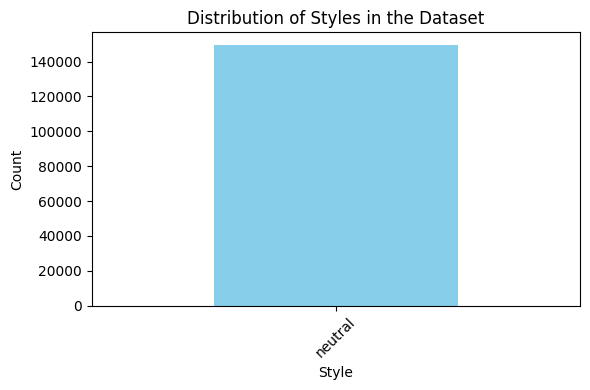


Random Sample of Examples:
Example 35703:
Input: Should I sell an iPhone 6s and buy an iPhone SE?
Output: Should I buy the iPhone 6s or an SE?
Style: neutral
--------------------------------------------------
Example 26735:
Input: What happened to the famous people who believed and confirmed the world would end in 2012 and what do they say why it didn't happen?
Output: What happened to people who sold off all their belongings in 2012 in preparation for the end of the world?
Style: neutral
--------------------------------------------------
Example 19217:
Input: What are some of the top paying career options after doing a B.Tech in mechanical engineering?
Output: What is the best field for earning money after completing a B.Tech in mechanical engineering?
Style: neutral
--------------------------------------------------
Example 79156:
Input: How can I use my time productively during slow day at work?
Output: What can I do on a boring day at work?
Style: neutral
-------------------------

In [9]:
import pandas as pd

# Step 1: Check for missing or ambiguous data
def check_data_quality(df):
    # Check for null values
    null_values = df.isnull().sum()
    print("Null Values in Each Column:")
    print(null_values)

    # Check for empty strings or nonsensical outputs
    invalid_outputs = df[df["output"].str.strip() == ""]
    print("\nRows with Empty Outputs:")
    print(invalid_outputs)

    # Check for duplicate pairs
    duplicate_pairs = df[df.duplicated(subset=["input", "output"])]
    print("\nDuplicate Input-Output Pairs:")
    print(duplicate_pairs)

# Apply data quality checks
check_data_quality(df)

# Step 2: Visualize style distribution
import matplotlib.pyplot as plt

style_distribution = df["style"].value_counts()
print("\nStyle Distribution:")
print(style_distribution)

plt.figure(figsize=(6, 4))
style_distribution.plot(kind="bar", color="skyblue")
plt.title("Distribution of Styles in the Dataset")
plt.xlabel("Style")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 3: Inspect a random sample of examples
print("\nRandom Sample of Examples:")
random_sample = df.sample(n=5, random_state=42)
for i, row in random_sample.iterrows():
    print(f"Example {i}:")
    print(f"Input: {row['input']}")
    print(f"Output: {row['output']}")
    print(f"Style: {row['style']}")
    print("-" * 50)

# Step 4: Save the cleaned dataset (optional)
cleaned_dataset_path = "cleaned_paraphrase_dataset.csv"
df.to_csv(cleaned_dataset_path, index=False)
print(f"\nCleaned dataset saved to: {cleaned_dataset_path}")

In [10]:
from transformers import T5Tokenizer

# Step 1: Load the tokenizer
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Step 2: Tokenize the dataset
def tokenize_function(example):
    # Format the input as "paraphrase: <input_text> style: <style>"
    inputs = [f"paraphrase: {text} style: {style}" for text, style in zip(example["input"], example["style"])]
    targets = example["output"]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply tokenization
tokenized_dataset = df.apply(tokenize_function, axis=1)

# Step 3: Save the tokenized dataset (optional)
tokenized_dataset_path = "tokenized_paraphrase_dataset.csv"
tokenized_dataset.to_csv(tokenized_dataset_path, index=False)
print(f"Tokenized dataset saved to: {tokenized_dataset_path}")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Tokenized dataset saved to: tokenized_paraphrase_dataset.csv


In [11]:
from sklearn.model_selection import train_test_split

# Load the tokenized dataset
df = pd.read_csv("tokenized_paraphrase_dataset.csv")

# Split the data into train (80%), validation (10%), and test (10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Save the splits to separate files (optional)
train_df.to_csv("train_dataset.csv", index=False)
val_df.to_csv("validation_dataset.csv", index=False)
test_df.to_csv("test_dataset.csv", index=False)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 119410
Validation set size: 14926
Test set size: 14927


In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
import torch

# Verify PyTorch and GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")

# Load the processed dataset
df = pd.read_csv("processed_paraphrase_dataset.csv")

# Load tokenizer and model
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Preprocess the dataset for T5
def preprocess_function(examples):
    inputs = [f"paraphrase: {text} style: {style}" for text, style in zip(examples['input'], examples['style'])]
    targets = examples['output']
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Convert the processed dataset to a Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Split into train and validation sets (90% train, 10% validation)
train_test_split = dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]

# Tokenize the datasets
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(preprocess_function, batched=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_steps=10_000,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=100,
    fp16=torch.cuda.is_available(),  # Enable mixed precision only if GPU is available
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
)

# Start training
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./fine_tuned_flan_t5")
tokenizer.save_pretrained("./fine_tuned_flan_t5")

print("Training completed and model saved!")

PyTorch version: 2.6.0+cu124
GPU available: True


Map:   0%|          | 0/134336 [00:00<?, ? examples/s]

Map:   0%|          | 0/14927 [00:00<?, ? examples/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.000000,nan
2,0.000000,nan
3,0.000000,nan


Training completed and model saved!


In [2]:
input_text = "paraphrase: How can I improve my skills? style: neutral"
inputs = tokenizer(input_text, return_tensors="pt", max_length=128, truncation=True).to("cuda")
outputs = model.generate(**inputs)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

if you are a professional, you can improve your skills.


In [4]:
import os
print(os.getcwd())

C:\Users\ASUS
